In [3]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk



In [4]:
# import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from scipy import ndimage

In [3]:
datapath = "/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/data"

In [4]:
# meta_df = []
# for i in range(300):
#     casepath = "case_" + str(i).zfill(5) + "/imaging.nii.gz"
#     img = os.path.join(datapath, casepath)
#     img = nib.load(img)
#     header = img.header
#     meta_df.append({"xdim" : header["dim"][2],
#     "ydim" : header["dim"][3],
#     "zdim" : header["dim"][1],
#     "xres" : header["pixdim"][2],
#     "yres" : header["pixdim"][3],
#     "zres" : header["pixdim"][1]})
# meta_df = pd.DataFrame(meta_df)

In [5]:
# meta_df.to_csv('meta_df.csv', index=False)
# meta_df

In [4]:
meta_df = pd.read_csv('meta_df.csv')
meta_df

,xdim,ydim,zdim,xres,yres,zres
0,512,512,611,0.919922,0.919922,0.5
1,512,512,602,0.798828,0.798828,0.5
2,512,512,261,0.939453,0.939453,1.0
3,512,512,270,0.855469,0.855469,1.0
4,512,512,64,0.976562,0.976562,4.0
...,...,...,...,...,...,...
295,512,512,564,0.919922,0.919922,0.5
296,512,512,83,0.621094,0.621094,5.0
297,512,512,102,0.740000,0.740000,5.0
298,512,512,617,0.734375,0.734375,0.5


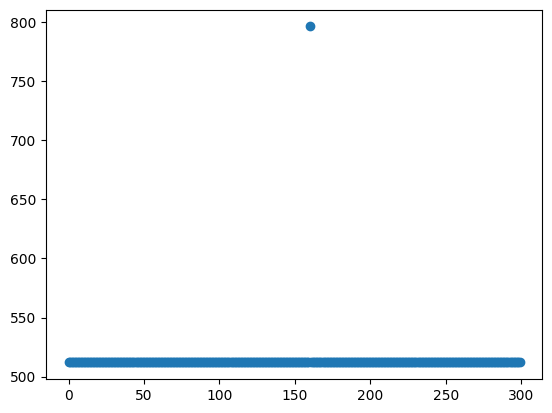

In [8]:
ydim = meta_df['ydim'].tolist()
plt.scatter(np.arange(0, 300), ydim)

In [7]:
for i, value in enumerate(ydim):
    if value != 512:
        print(f"Value {value} at index {i} is not equal to 512.")
ydim[160]

Value 796 at index 160 is not equal to 512.


796

____________________________________

# Data cleaning

1. Preprocessing: u-map and histograms of intensities
2. Resample to (1, 1, 5) isotropic resolution
3. Change intensities by converting negative values to zero
4. Implement correct labels: adverse if T-stage > 3 and ISUP > 3
5. Crop 3D image for only kidney slices
6. Identify region of interest to pass into Deep Learning Model

**Step 1: Analyze u-map and histograms of intensities**

In [ ]:
meta_df_xz = meta_df[['xres', 'zres']]
meta_df_xz

In [ ]:
reducer = umap.UMAP()
scaled_meta_df = StandardScaler().fit_transform(meta_df_xz)
scaled_meta_df

In [ ]:
embedding = reducer.fit_transform(scaled_meta_df)
embedding.shape

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of metadata', fontsize=18);

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming x_coords and y_coords are your arrays of x and y coordinates
# Create a list of coordinate pairs
coordinates = list(zip(embedding[:, 0], embedding[:, 1]))

# Choose the number of clusters (you may adjust this based on your data)
num_clusters = 8

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(coordinates)

# Get cluster labels for each point
cluster_labels = kmeans.labels_

# Plot the scatterplot with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('Scatterplot with Cluster Labels')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
meta_df['cluster_label'] = cluster_labels

# Group by cluster_label and calculate the means
cluster_means = meta_df.groupby('cluster_label').mean()

# Display the average x, y, and z resolutions for each cluster
print(cluster_means)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming x_coords and y_coords are your arrays of x and y coordinates
# Assuming df is your DataFrame with x, y, and z resolutions

# Create a list of coordinate pairs
coordinates = list(zip(embedding[:, 0], embedding[:, 1]))

# Assuming you have cluster_labels from earlier clustering
# Fit KMeans to find centroids
kmeans = KMeans(n_clusters=8)
kmeans.fit(coordinates)

# Get cluster centroids
cluster_centroids = kmeans.cluster_centers_

# Plot the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, label='Data Points')
plt.title('Scatterplot with Cluster Labels')
plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.colorbar(label='Cluster')

for index, centroid in enumerate(cluster_centroids):
    # Get the mean xres and zres for the current cluster
    mean_xres = cluster_means.loc[index, 'xres']
    mean_zres = cluster_means.loc[index, 'zres']
    
    plt.annotate(f'XRes: {mean_xres:.2f}\nZRes: {mean_zres:.2f}',
                 centroid, xytext=(5, 5), textcoords='offset points',
                 ha='left', va='bottom', fontsize=8)

plt.legend()
plt.show()


In [ ]:
# Generate array of intensities of each frame for a certain patient patient_num
patient_num = 0
intensities = []
casepath = "case_" + str(patient_num).zfill(5) + "/imaging.nii.gz"
path = os.path.join(datapath, casepath)
curr_img = sitk.ReadImage(path)
intensities = sitk.GetArrayFromImage(curr_img)

In [ ]:
# Histogram of intensities exluding -1024

flat_list = intensities.flatten()
flat_list = flat_list[flat_list != -1024.0]

plt.figure(figsize=(8, 5))
plt.hist(flat_list, bins=np.arange(min(flat_list), max(flat_list) + 1), edgecolor='black')
plt.title('Histogram of Intensities vs Frequencies')
plt.xlabel('Intensities')
plt.ylabel('Frequencies')
plt.grid(axis='y', alpha=0.5)
plt.show()

**Step 2: Resample to (1, 1, 5) isotropic resolution**

In [9]:
# DF that has each of the 300 samples as rows and dims and res as columns:
meta_df

,xdim,ydim,zdim,xres,yres,zres
0,512,512,611,0.919922,0.919922,0.5
1,512,512,602,0.798828,0.798828,0.5
2,512,512,261,0.939453,0.939453,1.0
3,512,512,270,0.855469,0.855469,1.0
4,512,512,64,0.976562,0.976562,4.0
...,...,...,...,...,...,...
295,512,512,564,0.919922,0.919922,0.5
296,512,512,83,0.621094,0.621094,5.0
297,512,512,102,0.740000,0.740000,5.0
298,512,512,617,0.734375,0.734375,0.5


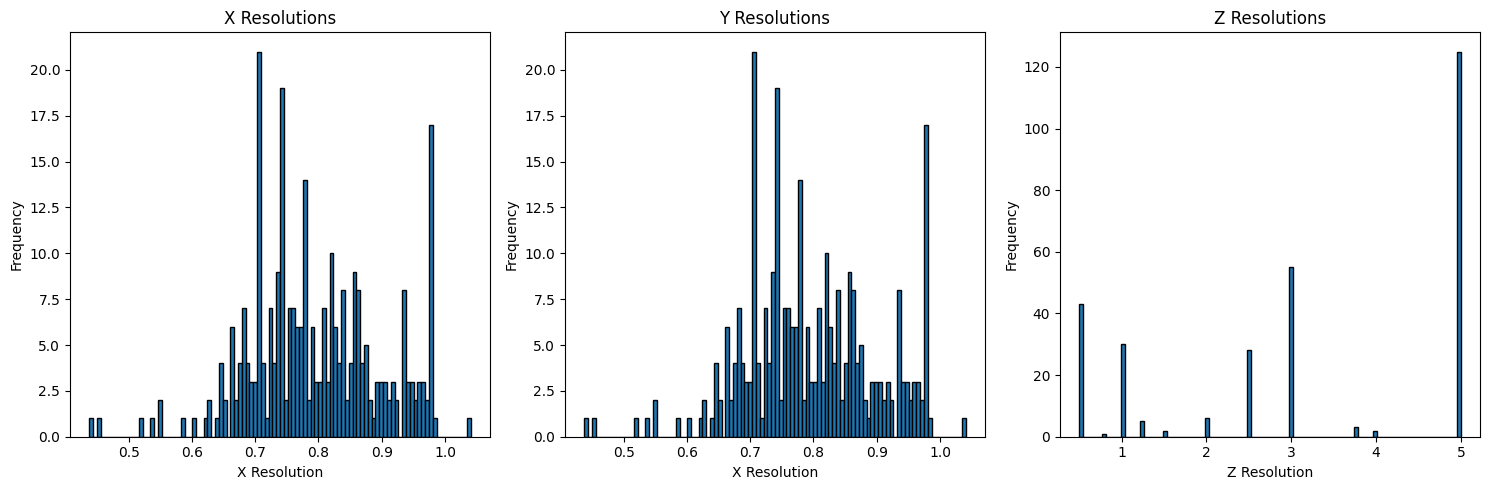

In [10]:
xres = meta_df['xres'].tolist()
yres = meta_df['yres'].tolist()
zres = meta_df['zres'].tolist()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creating subplots with 1 row and 3 columns

axs[0].hist(xres, bins=100, edgecolor='black')
axs[0].set_xlabel('X Resolution')
axs[0].set_ylabel('Frequency')
axs[0].set_title('X Resolutions')

axs[1].hist(yres, bins=100, edgecolor='black')
axs[1].set_xlabel('X Resolution')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Y Resolutions')

axs[2].hist(zres, bins=100, edgecolor='black')
axs[2].set_xlabel('Z Resolution')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Z Resolutions')

plt.tight_layout()  # Adjusts subplots to prevent overlap
plt.show()

In [15]:
def resample_volume(volume, interpolator = sitk.sitkLinear, new_spacing = [5, 1, 1]):
#     volume = sitk.ReadImage(volume_path, sitk.sitkFloat32) # read and cast to float32
    original_spacing = volume.GetSpacing()
    original_size = volume.GetSize()
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                         volume.GetOrigin(), new_spacing, volume.GetDirection(), 0,
                         volume.GetPixelID())

In [16]:
intensities_resampled = sitk.GetArrayFromImage(img0_resampled)
flat_list_resampled = intensities_resampled.flatten()
flat_list_resampled = flat_list_resampled[flat_list_resampled != -1024.0]

plt.figure(figsize=(8, 5))
plt.hist(flat_list_resampled, bins=np.arange(min(flat_list_resampled), max(flat_list_resampled) + 1), edgecolor='black')
plt.title('Histogram of Intensities vs Frequencies')
plt.xlabel('Intensities')
plt.ylabel('Frequencies')
plt.grid(axis='y', alpha=0.5)
plt.show()

NameError: name 'img0_resampled' is not defined

In [17]:
# Save all resampled imgs to array resampledImgs
resampledImgs = []
for i in range(300):
    casepath = "case_" + str(i).zfill(5) + "/imaging.nii.gz"
    path = os.path.join(datapath, casepath)
    print(i)
    resampledImgs.append(resample_volume(path))

0


AttributeError: 'str' object has no attribute 'GetSpacing'

In [19]:
# df_res = []
# for i in range(300):
#     img = resampledImgs[i]
# #     print(img.GetDimension())
#     res = img.GetSpacing()
#     df_res.append({"xdim" : img.GetDepth(),
#     "ydim" : img.GetHeight(),
#     "zdim" : img.GetWidth(),
#     "xres" : res[1],
#     "yres" : res[2],
#     "zres" : res[0]})
# df_res = pd.DataFrame(df_res)
# df_res

,xdim,ydim,zdim,xres,yres,zres
0,471,471,61,1.0,1.0,5.0
1,409,409,60,1.0,1.0,5.0
2,481,481,52,1.0,1.0,5.0
3,438,438,54,1.0,1.0,5.0
4,500,500,51,1.0,1.0,5.0
...,...,...,...,...,...,...
295,471,471,56,1.0,1.0,5.0
296,318,318,83,1.0,1.0,5.0
297,379,379,102,1.0,1.0,5.0
298,376,376,62,1.0,1.0,5.0


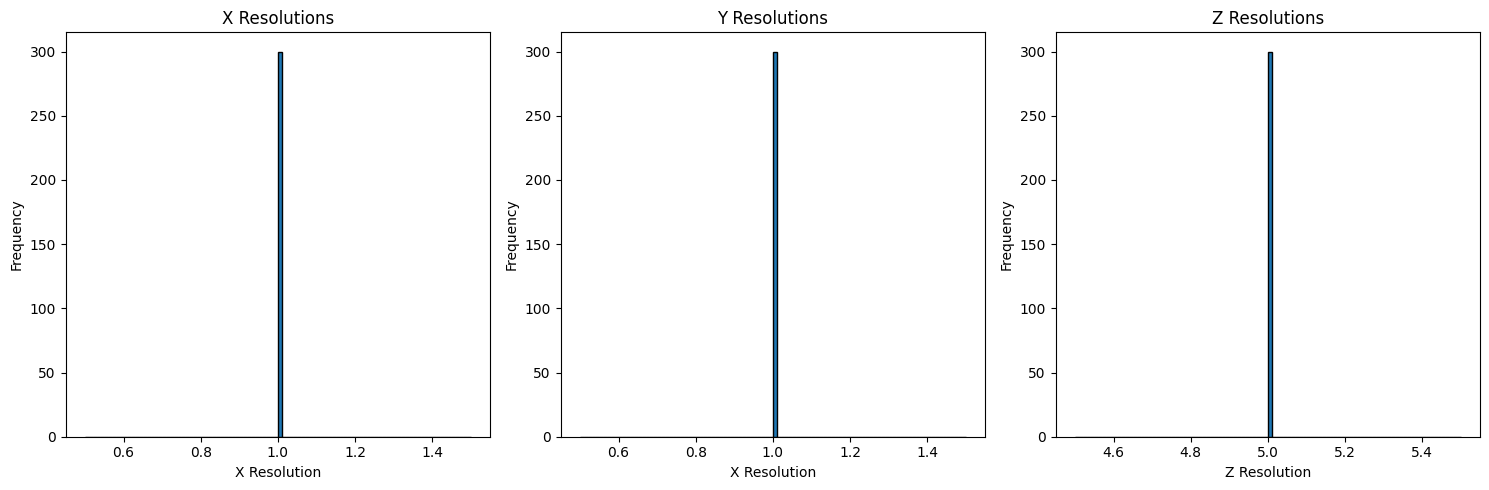

In [19]:
# xres = df_res['xres'].tolist()
# yres = df_res['yres'].tolist()
# zres = df_res['zres'].tolist()

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creating subplots with 1 row and 3 columns

# axs[0].hist(xres, bins=100, edgecolor='black')
# axs[0].set_xlabel('X Resolution')
# axs[0].set_ylabel('Frequency')
# axs[0].set_title('X Resolutions')

# axs[1].hist(yres, bins=100, edgecolor='black')
# axs[1].set_xlabel('X Resolution')
# axs[1].set_ylabel('Frequency')
# axs[1].set_title('Y Resolutions')

# axs[2].hist(zres, bins=100, edgecolor='black')
# axs[2].set_xlabel('Z Resolution')
# axs[2].set_ylabel('Frequency')
# axs[2].set_title('Z Resolutions')

# plt.tight_layout()  # Adjusts subplots to prevent overlap
# plt.show()


**Step 3: Hounsfield Units, 0 to 1 Rescaling**

In [25]:
def normalise150200(image):
    np_img = image
    np_img = np.clip(np_img, -150., 200.).astype(np.float32)
    return np_img

def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret

def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""
    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret

**Step 4: Implement correct labels: adverse if T-stage > 3 and ISUP > 3**

In [5]:
labels = pd.read_csv('/Users/dhruv/Downloads/KiTS21_ClinicalData.csv')

labels['case_id'] = pd.to_numeric(labels['case_id'].str.extract(r'(\d+)', expand=False), errors='coerce')

labels = labels[['case_id', 'pathology_t_stage', 'tumor_isup_grade']]

labels = labels.rename(columns={"pathology_t_stage": "T-grade", "tumor_isup_grade": "ISUP"})

labels['ISUP'] = labels['ISUP'].replace([1.0, 2.0], 0)
labels['ISUP'] = labels['ISUP'].replace([3.0, 4.0], 1)
labels = labels.fillna(0)
labels['ISUP'] = labels['ISUP'].astype(int)

labels['T-grade'] = labels['T-grade'].replace(['1a', '1b', '2a', '2b'], 0)
labels['T-grade'] = labels['T-grade'].replace(['3', '4'], 1)
labels = labels.fillna(0)

labels['Joint'] = (labels['ISUP'] == 1) & (labels['T-grade'] == 1)
labels['Joint'] = labels['Joint'].astype(int)

labels.head(10)

joint_array = labels['Joint'].values
np.save('./joint_labels.npy', joint_array)

**Step 5: Crop around tumor regions**

In [18]:
# Generate cuboid coordinates
cuboid_coords = []
for i in range(1):
    print(i)
    casepath = "case_" + str(i).zfill(5) + "/aggregated_AND_seg.nii.gz"
    img_path = os.path.join(datapath, casepath)
    img_arr = sitk.GetArrayFromImage(sitk.ReadImage(img_path)) 
    
#     img_arr = ndimage.zoom(img_arr, [n / float(o) for n, o in zip((112, 112, 112), img_arr.shape)])
    
    indices = np.where(img_arr == 2)
    
    # Cuboid extends -5 and +5 pixels from min and max tumor pixels:
    curr_min_coords = [x - 5 for x in np.min(indices, axis=1)]
    curr_max_coords = [x + 5 for x in np.max(indices, axis=1)]
    
    # Make sure the cuboid is within the image boundaries:
    curr_min_coords[2] = max(0, min(curr_min_coords[2], img_arr.shape[2]))
    curr_max_coords[2] = max(0, min(curr_max_coords[2], img_arr.shape[2]))
    
    cuboid_coords.append((curr_min_coords, curr_max_coords))

0


HDF5-DIAG: Error detected in HDF5 (1.12.1) thread 0:
  #000: /tmp/SimpleITK-build/ITK/Modules/ThirdParty/HDF5/src/itkhdf5/src/H5Fdeprec.c line 156 in itk_H5Fis_hdf5(): unable to determine if file is accessible as HDF5
    major: File accessibility
    minor: Not an HDF5 file
  #001: /tmp/SimpleITK-build/ITK/Modules/ThirdParty/HDF5/src/itkhdf5/src/H5VLcallback.c line 3769 in itk_H5VL_file_specific(): file specific failed
    major: Virtual Object Layer
    minor: Can't operate on object
  #002: /tmp/SimpleITK-build/ITK/Modules/ThirdParty/HDF5/src/itkhdf5/src/H5VLcallback.c line 3699 in H5VL__file_specific(): file specific failed
    major: Virtual Object Layer
    minor: Can't operate on object
  #003: /tmp/SimpleITK-build/ITK/Modules/ThirdParty/HDF5/src/itkhdf5/src/H5VLnative_file.c line 384 in itk_H5VL__native_file_specific(): error in HDF5 file check
    major: File accessibility
    minor: Unable to initialize object
  #004: /tmp/SimpleITK-build/ITK/Modules/ThirdParty/HDF5/src/itkhd

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/data/case_00000/aggregated_AND_seg.nii.gz"

In [20]:
cuboid_coords

[([156, 303, 284], [193, 341, 346]),
 ([96, 247, 250], [151, 313, 361]),
 ([313, 347, 149], [370, 398, 203]),
 ([130, 252, 170], [174, 294, 210]),
 ([357, 272, 33], [399, 312, 51]),
 ([371, 262, 239], [436, 326, 372]),
 ([293, 281, 35], [339, 325, 56]),
 ([111, 250, 28], [156, 296, 47]),
 ([107, 188, 111], [237, 346, 159]),
 ([285, 327, 18], [326, 364, 36]),
 ([287, 261, 5], [336, 314, 24]),
 ([351, 276, 7], [433, 353, 26]),
 ([285, 215, 11], [422, 323, 38]),
 ([119, 279, 30], [190, 351, 53]),
 ([164, 282, 98], [198, 320, 132]),
 ([316, 259, 46], [367, 314, 69]),
 ([362, 257, 45], [430, 341, 73]),
 ([100, 313, 30], [147, 349, 45]),
 ([153, 293, 54], [200, 337, 77]),
 ([332, 252, 36], [357, 276, 50]),
 ([306, 301, 20], [342, 337, 35]),
 ([304, 239, 7], [360, 288, 24]),
 ([168, 221, 307], [211, 261, 360]),
 ([149, 287, 42], [185, 319, 58]),
 ([116, 194, 28], [214, 297, 49]),
 ([296, 226, 30], [444, 383, 80]),
 ([94, 194, 157], [182, 296, 204]),
 ([112, 280, 347], [146, 314, 402]),
 ([67,

[156, 303, 284]
[193, 341, 346]


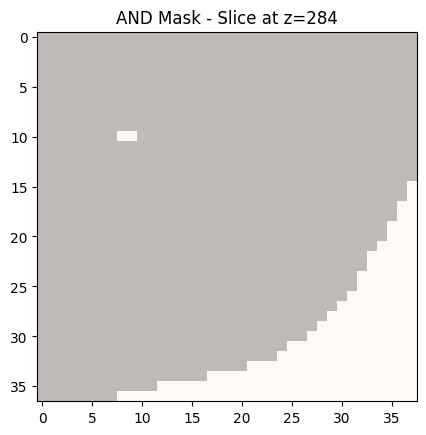

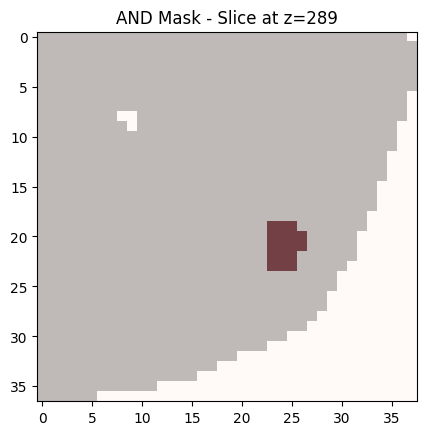

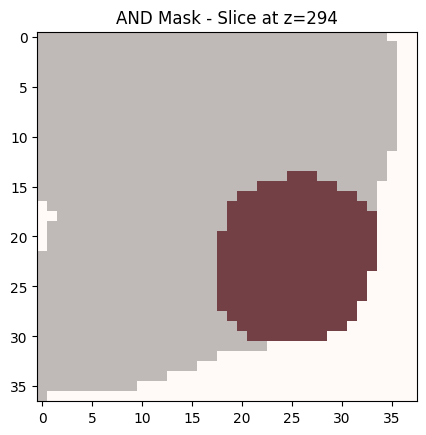

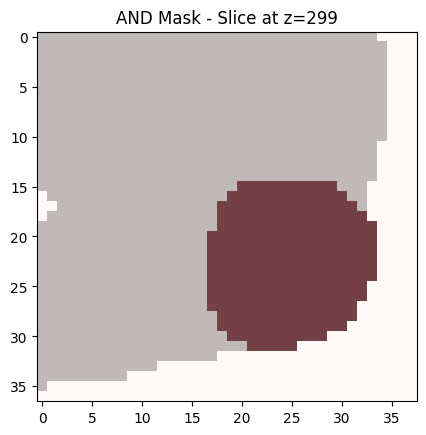

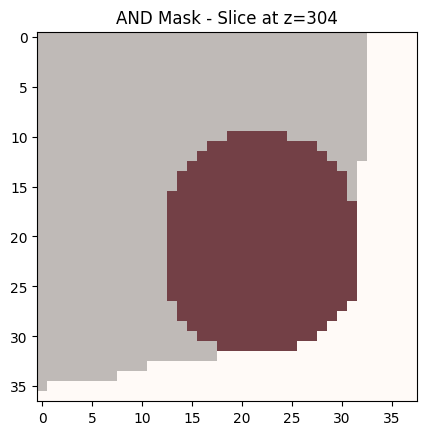

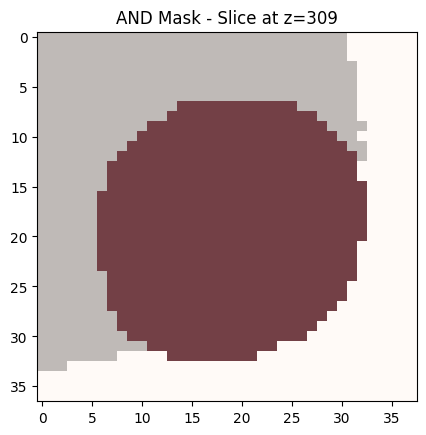

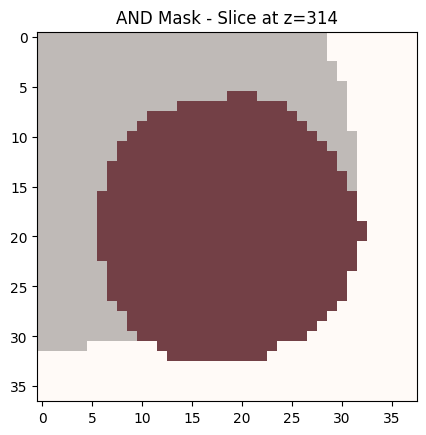

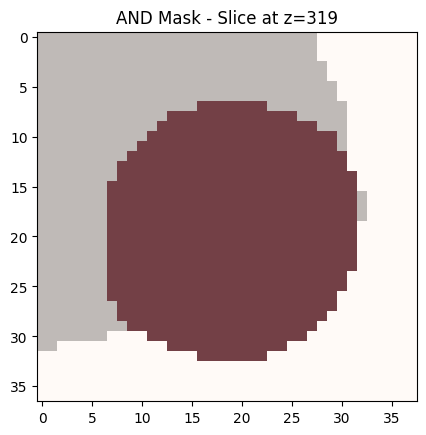

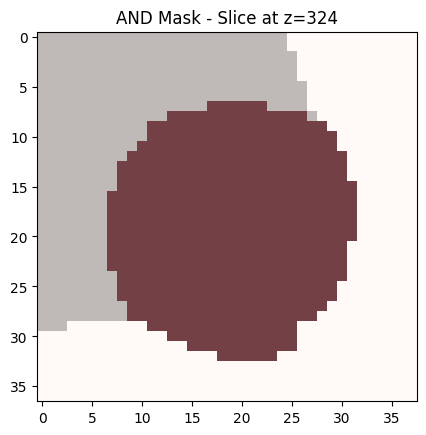

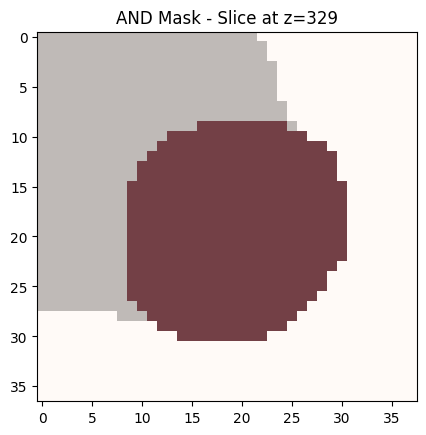

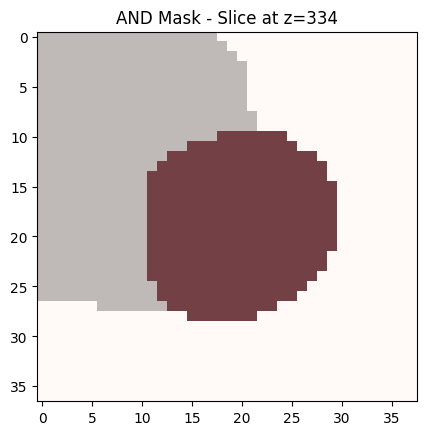

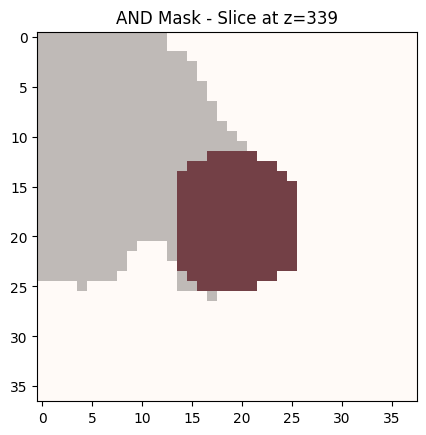

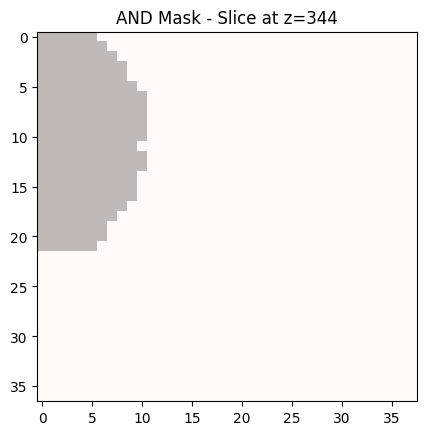

In [93]:
# Plotting mask regions within cuboid

case_num = 0
caseMaskPath = "case_" + str(case_num).zfill(5) + "/aggregated_AND_seg.nii.gz"
a0 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, caseMaskPath)))
# a0 = ndimage.zoom(a0, [n / float(o) for n, o in zip((112, 112, 112), a0.shape)])

min_coords = cuboid_coords[case_num][0]
max_coords = cuboid_coords[case_num][1]
print(min_coords)
print(max_coords)

for z in range(min_coords[2], max_coords[2], 5):
    img = a0[min_coords[0]: max_coords[0], min_coords[1]: max_coords[1], z]
    # Create a mask for values 1 and 2
    mask_1 = img == 0
    mask_2 = img == 2
    
    # Plotting with custom colors
    plt.imshow(mask_1, cmap='gray', alpha=0.5)  # Plot 1s as gray with transparency
    plt.imshow(mask_2, cmap='Reds', alpha=0.5)  # Plot 2s as black with transparency
    
    plt.title(f"AND Mask - Slice at z={z}")
    plt.show()

Number of 0s: 67655
Number of 1s: 19517


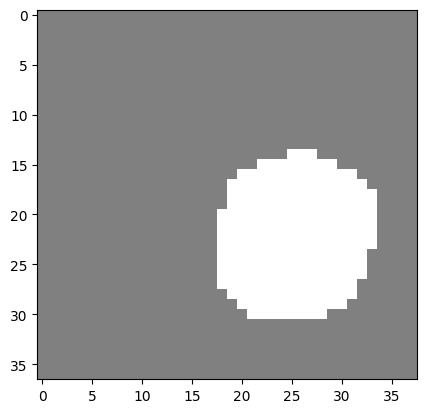

In [94]:
# Plotting mask with tumor(2) vs non-tumor(0 or 1)

case_num = 0
slice_num = 10
min_coords = cuboid_coords[case_num][0]
max_coords = cuboid_coords[case_num][1]
caseMaskPath = "case_" + str(case_num).zfill(5) + "/aggregated_AND_seg.nii.gz"
a0 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, caseMaskPath)))
# a0 = ndimage.zoom(a0, [n / float(o) for n, o in zip((112, 112, 112), a0.shape)])
img = a0[min_coords[0]: max_coords[0], min_coords[1]: max_coords[1], min_coords[2]: max_coords[2]]
mask_2 = (img == 2)
plt.imshow(mask_2[:, :, slice_num], cmap='gray', alpha=0.5)
count_0 = np.sum(mask_2 == 0)
count_1 = np.sum(mask_2 == 1)
print("Number of 0s:", count_0)
print("Number of 1s:", count_1)

In [ ]:
# Cuboid cropped image

casepath = "case_" + str(0).zfill(5) + "/imaging.nii.gz"
img0 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, casepath)))
# img0 = ndimage.zoom(img0, [n / float(o) for n, o in zip((112, 112, 112), img0.shape)])
print(img0.shape)
img_crop = img0[min_coords[0]: max_coords[0], min_coords[1]: max_coords[1], min_coords[2]: max_coords[2]]
plt.imshow(img_crop[:, :, slice_num], cmap='gray', alpha=0.5)

In [ ]:
# Mask overlay on cropped image

overlay = mask_2[:, :, slice_num] * img_crop[:, :, slice_num]
plt.imshow(overlay, cmap='gray', alpha=0.5)

**Step 6: Provide output: rescaled cropped images and masks**

In [29]:
final_imgs = []
for i in range(300):
    print(i)
    casepath = "case_" + str(i).zfill(5) + "/imaging.nii.gz"
    img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, casepath)))

    # Crop img using rescaled mask tumor cuboid
    min_coords = cuboid_coords[i][0]
    max_coords = cuboid_coords[i][1]
    img = img[min_coords[0]: max_coords[0], min_coords[1]: max_coords[1], min_coords[2]: max_coords[2]]

    # Isotropic Normalization
    sitk_img = sitk.GetImageFromArray(img)
    img = sitk.GetArrayFromImage(resample_volume(sitk_img))

    # Apply step 3: Hounsfield Units and normalize -1 to 1
    img = normalise150200(img)
    img = normalise_one_one(img)

    # Rescale image to (112, 112, 112)
    img = ndimage.zoom(img, [n / float(o) for n, o in zip((112, 112, 112), img.shape)])
    
    final_imgs.append(img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
casepath = "case_" + str(0).zfill(5) + "/aggregated_AND_seg.nii.gz"
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, casepath)))
# Rescale image to (112, 112, 112)
img = ndimage.zoom(img, [n / float(o) for n, o in zip((112, 112, 112), img.shape)])

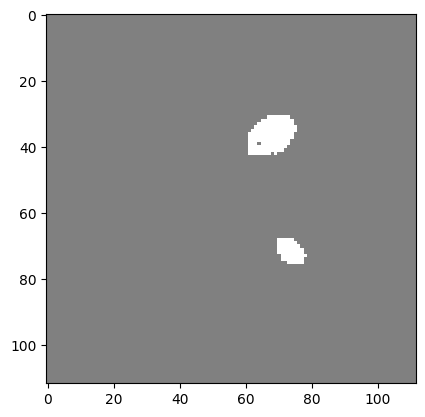

In [23]:
plt.imshow(img[:, :, 50], cmap='gray', alpha=0.5)

In [19]:
casepath = "case_" + str(0).zfill(5) + "/imaging.nii.gz"
img1 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, casepath)))
# Rescale image to (112, 112, 112)
img1 = ndimage.zoom(img, [n / float(o) for n, o in zip((112, 112, 112), img.shape)])

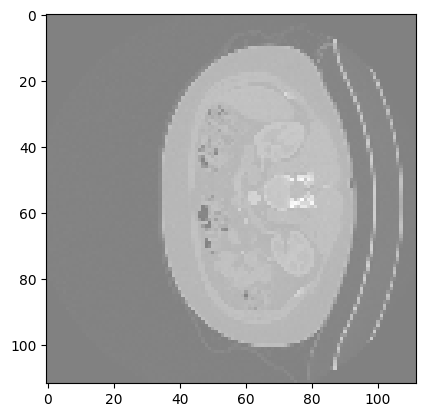

In [20]:
plt.imshow(img1[:, :, 40], cmap='gray', alpha=0.5)

In [7]:
masks = []
for i in range(300):
    print(i)
    casepath = "case_" + str(i).zfill(5) + "/aggregated_AND_seg.nii.gz"
    img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(datapath, casepath)))

    # Rescale image to (112, 112, 112)
    img = ndimage.zoom(img, [n / float(o) for n, o in zip((112, 112, 112), img.shape)])
    
    masks.append(img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


KeyboardInterrupt: 

In [ ]:
labels.head(10)

In [9]:
labels["Joint"].value_counts()

Joint
0    250
1     50
Name: count, dtype: int64

**Save images and masks as Nifti format in seperate folders**

In [40]:
imgS = final_imgs[0]
imgN = nib.Nifti1Image(imgS, affine=np.eye(4))
imgN

In [54]:
final_imgs[0].shape

(112, 112, 112)

In [46]:
np.array(imgN.dataobj).shape

(112, 112, 112)

In [6]:
imgPath = '/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/images_out/'
maskPath = '/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/masks_out/'
# os.makedirs(imgPath)
# os.makedirs(maskPath)
# for i in range(300):
#     nib.save(nib.Nifti1Image(final_imgs[i], affine=np.eye(4)), imgPath + 'img_' + str(i) + '.nii')
#     nib.save(nib.Nifti1Image(masks[i], affine=np.eye(4)), maskPath + 'mask_' + str(i) + '.nii')

---------

Reread and Display

In [8]:
import shutil


In [18]:

final_img='/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/images_out/img_0.nii'


In [22]:
shutil.copy(final_img, "/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/")

TimeoutError: [Errno 60] Operation timed out: '/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/images_out/img_0.nii' -> '/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/img_0.nii'

In [23]:
masks=np.load(maskPath + 'mask_0.nii')

TimeoutError: [Errno 60] Operation timed out

In [14]:
input_labels=np.load('./joint_labels.npy')
input_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])

In [20]:
# final_img='/Users/dhruv/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/kits21/kits21/images_out'
os.listdir(imgPath)

['img_120.nii',
 'img_134.nii',
 'img_108.nii',
 'img_27.nii',
 'img_33.nii',
 'img_256.nii',
 'img_242.nii',
 'img_295.nii',
 'img_281.nii',
 'img_280.nii',
 'img_294.nii',
 'img_243.nii',
 'img_257.nii',
 'img_32.nii',
 'img_26.nii',
 'img_109.nii',
 'img_135.nii',
 'img_121.nii',
 'img_137.nii',
 'img_123.nii',
 'img_18.nii',
 'img_30.nii',
 'img_24.nii',
 'img_241.nii',
 'img_255.nii',
 'img_269.nii',
 'img_9.nii',
 'img_282.nii',
 'img_296.nii',
 'img_297.nii',
 'img_283.nii',
 'img_8.nii',
 'img_268.nii',
 'img_254.nii',
 'img_240.nii',
 'img_25.nii',
 'img_31.nii',
 'img_19.nii',
 'img_122.nii',
 'img_136.nii',
 'img_132.nii',
 'img_126.nii',
 'img_35.nii',
 'img_21.nii',
 'img_278.nii',
 'img_244.nii',
 'img_250.nii',
 'img_287.nii',
 'img_293.nii',
 'img_292.nii',
 'img_286.nii',
 'img_251.nii',
 'img_245.nii',
 'img_279.nii',
 'img_20.nii',
 'img_34.nii',
 'img_127.nii',
 'img_133.nii',
 'img_119.nii',
 'img_125.nii',
 'img_131.nii',
 'img_22.nii',
 'img_36.nii',
 'img_253.ni